#TEXT MINING


1. Sentimental Binary Classification

Welcome to the "Sentimental Binary Classification" section of the Text Mining Notebook! In this segment, we explore the fascinating realm of sentiment analysis, focusing on binary classification. Sentiment analysis involves determining the emotional tone expressed in a piece of text, and binary classification simplifies this task by categorizing text into positive or negative sentiments. This notebook leverages machine learning techniques to train a model that classifies text data into these two categories.


2. Sentiment Scoring

In the "Sentiment Scoring" section of the Text Mining Notebook, we dive deeper into sentiment analysis by assigning numerical scores to text data based on the intensity of sentiments. Unlike binary classification, sentiment scoring provides a more nuanced understanding of sentiment strength, allowing for a finer-grained analysis. This notebook explores methods to score sentiments in text using machine learning and natural language processing techniques, providing insights into the varying degrees of positivity or negativity expressed in the text.


3. Word Pairs

Welcome to the "Word Pairs" section of the Text Mining Notebook! Here, we shift our focus to uncovering meaningful associations between words in text data. Analyzing word pairs provides valuable insights into the relationships and connections between different terms, enhancing our understanding of the context in which they appear. This notebook explores techniques for identifying and analyzing word pairs, shedding light on the intricate patterns and connections within the text data.




# "THE ILIAD" AT PROJECT GUTENBERG

- [Project Gutenberg](https://www.gutenberg.org) provides over 60,000 free e-books.
- For these demonstrations, we'll use "The Iliad" by Homer, which is located at http://www.gutenberg.org/ebooks/6150.
- We'll use the plain text version, which I have already downloaded and saved to the data folder as `Iliad.txt`.

In [37]:
# Import libraries
import re  # For regular expressions
import nltk  # For text functions
import matplotlib.pyplot as plt  # For plotting
import pandas as pd  # For dataframes
from afinn import Afinn  # For sentiment values

# Import corpora and functions from NLTK
from nltk.corpus import stopwords
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize
import networkx as nx  # For network graphs

# Download data for NLTK
nltk.download('stopwords', quiet=True)
nltk.download('opinion_lexicon', quiet=True)
nltk.download('punkt', quiet=True)



True

# LOAD DATA

- You can import the text and display the first few lines with this code:

In [11]:
df = pd.read_csv('/content/Iliad.txt',sep='\t')\
    .dropna()\
    .drop('gutenberg_id', 1)

df.head(10)

<ipython-input-11-294200ea29be>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  .drop('gutenberg_id', 1)


,text
0,THE ILIAD OF HOMER
2,RENDERED INTO ENGLISH BLANK VERSE.
3,BY
5,EDWARD EARL OF DERBY.
10,PREFACE.
13,"In the spring of 1862 I was induced, at the re..."
14,"friends, to print, for private circulation onl..."
15,"""Translations of Poems Ancient and Modern,"" in..."
16,first Book of the Iliad. The opinions expresse...
17,judges of the degree of success which had atte...


# BINARY CLASSIFICATION OF SENTIMENT

STEP1: Tokenize the text

In [13]:
#  A "token" is the level of analysis for text mining.
#  In this case, the tokens will be individual words, which is most common, but tokens can also be pairs or triplets of words, sentences, and so on.
#  In the tokenization process, it is common to standardize capitalization and remove non-word characters.

def clean_text(text):
    text = text.lower()                    # Convert all text to lowercase
    text = text.replace("'", '')
    text = re.sub(r'[^\w]', ' ', text)     # Leave only word characters
    text = re.sub(r'\s+', ' ', text)       # Omit extra space characters
    text = text.strip()
    return text

df['text'] = df['text'].map(clean_text)
df['text'] = df['text'].map(word_tokenize)  # Split text into word tokens

df.head()

,text
0,"[the, iliad, of, homer]"
2,"[rendered, into, english, blank, verse]"
3,[by]
5,"[edward, earl, of, derby]"
10,[preface]


In [17]:
## Collect Tokens into a Single Series
df = df.text.explode().to_frame('token')
df.head(10)

## Sort Tokens by Frequency
df.token.value_counts().head(10)

## Remove Stop Words
stopwords = set(stopwords.words('english')) # load stopwords
df = df[~df.token.isin(stopwords)]

## Sort Revised Tokens by Frequency
df.token.value_counts().head(10)

son         867
thou        756
thus        731
thy         688
greeks      529
achilles    445
hector      429
ships       423
thee        421
th          396
Name: token, dtype: int64

 CLASSIFY SENTIMENTS

- Identify Valenced Words with the "Opinion" Lexicon

In [19]:
sentiment_lexicon = {
    **{w: 'positive' for w in opinion_lexicon.positive()},
    **{w: 'negative' for w in opinion_lexicon.negative()}
}

df['sentiment'] = df['token'].map(sentiment_lexicon)
df = df[~df.sentiment.isna()] # ommit words out of opinion lexicon
## Sort Sentiment Words by Frequency
df.token.value_counts().head(10)

## Summarize the Sentiment Words

summary_df = df.sentiment.value_counts().to_frame('n')
summary_df['prop'] = summary_df['n'] / summary_df.n.sum()

summary_df.round(3)

,n,prop
negative,6387,0.552
positive,5194,0.448


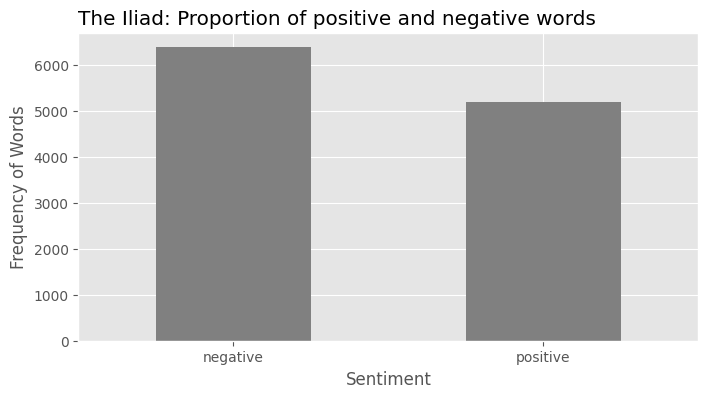

In [20]:
summary_df.n.plot.bar(legend=False, figsize=(8, 4), grid=True, color='gray')
plt.xlabel('Sentiment')
plt.ylabel('Frequency of Words')
plt.title('The Iliad: Proportion of positive and negative words', loc='left')
plt.xticks(rotation=0);

# SENTIMENT SCORING

In [35]:
# Splitting the score in lines:
df['line'] = range(1, len(df) + 1)

df.head()

,token,line,score
16,competent,1,2
17,success,2,2
18,spirit,3,1
19,simplicity,4,1
19,great,5,3


SCORE SENTIMENTS

- Calculate sentiment scores using the AFINN lexicon, which scores words on a scale of -5 (most negative) to +5 (most positive).

In [30]:
afinn_scorer = Afinn()

df['score'] = df['token'].map(afinn_scorer.score).astype(int)
df = df[df['score'] != 0]

score_freq = df.score.value_counts().sort_index().to_frame('n')

score_freq



,n
-5,12
-4,9
-3,817
-2,2612
-1,1679
1,1269
2,2590
3,759
4,110


- Graph Score Frequencies

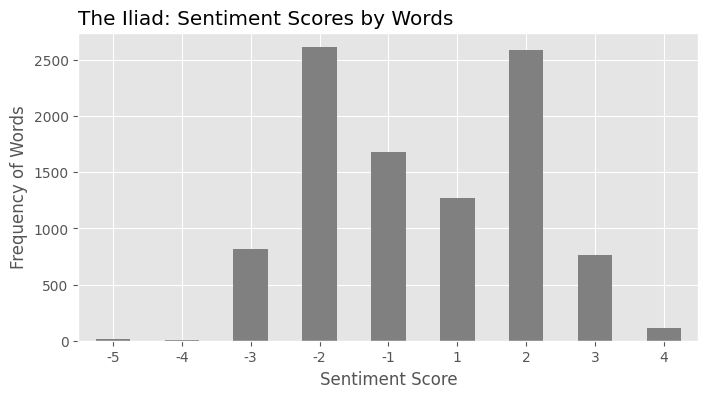

In [31]:
score_freq.plot.bar(
    legend=False,
    figsize=(8, 4),
    grid=True,
    color='gray')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency of Words')
plt.title('The Iliad: Sentiment Scores by Words', loc='left')
plt.xticks(rotation=0);

 SENTIMENT ARC
- Divide the text into sections of 100 lines and calculate a sentiment score for each section.

In [32]:
score_acc = df.groupby(df['line'] // 100)\
    .score.mean()\
    .to_frame('score')\
    .rename_axis('section')

score_acc.head(10)

,score
section,
0,0.805970
1,-0.396825
2,-0.153846
3,0.306452
4,-0.244444
5,-0.142857
6,-0.150943
7,0.060000
8,-0.175439


- Plot Scores by Section to View Narrative Arc

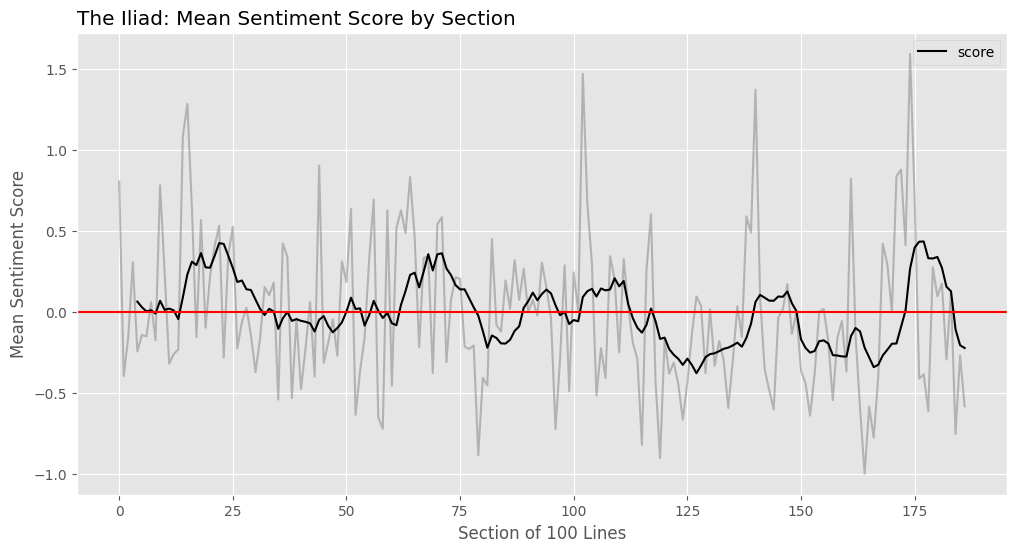

In [33]:
ax = score_acc.plot.line(legend=False, figsize=(12, 6), grid=True, alpha=0.5, color='gray')
score_acc.rolling(10, min_periods=5).mean().plot.line(ax=ax, color='black')
plt.xlabel('Section of 100 Lines')
plt.ylabel('Mean Sentiment Score')
plt.title('The Iliad: Mean Sentiment Score by Section', loc='left')
plt.axhline(0, color='red')
plt.xticks(rotation=0);

# WORD PAIRS

In [44]:
## CREATE WORD PAIR TOKENS

# Instead of splitting the text into single words, separate it into pairs of adjacent words.
df['wordpairs'] = df['text'].map(lambda x: list(ngrams(x, 2)))
df = df.explode('wordpairs')

## Sort the Tokens by Frequency
df['wordpairs'].value_counts().head(10)

(to, the)        32012
(of, the)        29967
(in, the)        27220
(from, the)      24415
(the, greeks)    19275
(on, the)        17148
(all, the)       12928
(the, ships)     12340
(by, the)        11957
(and, the)       11608
Name: wordpairs, dtype: int64

In [45]:
## Split Word Pairs

## In order to remove word pairs with stop words, the pairs must first be separated.
## Separated pairs are also necessary for creating network graphs.

df = pd.DataFrame(df.wordpairs.values.tolist(), columns=['word1', 'word2']).dropna()
df.head(10)

,word1,word2
0,the,iliad
1,iliad,of
2,of,homer
3,the,iliad
4,iliad,of
5,of,homer
6,the,iliad
7,iliad,of
8,of,homer
9,the,iliad


In [46]:
## Remove Stop Words
## This reduces the total number of observations from 127,709 to 33,694, a 74% reduction.

en_stopwords = set(stopwords.words('english'))

df = df[~(df.word1.isin(en_stopwords) | df.word2.isin(en_stopwords))]

df.head()

,word1,word2
29,english,blank
30,blank,verse
33,english,blank
34,blank,verse
37,english,blank


In [49]:
## Sort Word Pairs by Frequency

df = df.groupby(['word1', 'word2'])\
    .size()\
    .to_frame('n')\
    .reset_index()\
    .sort_values('n', ascending=False)

df.head(10)

,word1,word2,n
0,151,chthizos,1
15463,resistless,hand,1
15461,resist,mars,1
15460,reserve,thy,1
15459,resenting,thus,1
15458,rescue,thee,1
15457,rescue,fight,1
15456,rescue,come,1
15455,rescue,came,1
15454,requiring,sore,1


- VISUALIZE DATA

In [48]:
## Create Data Table

# Restrict to word pairs that appear more than 12 times.
df[df.n > 12].head(10)

,word1,word2,n
13491,old,man,3187
19226,thou,art,2205
14197,peleus,son,2138
18855,th,immortal,2020
16053,saturns,son,1976
19305,thou,hast,1883
22209,well,wrought,1801
1723,battle,field,1769
19687,thus,addressd,1738
7570,glancing,helm,1711


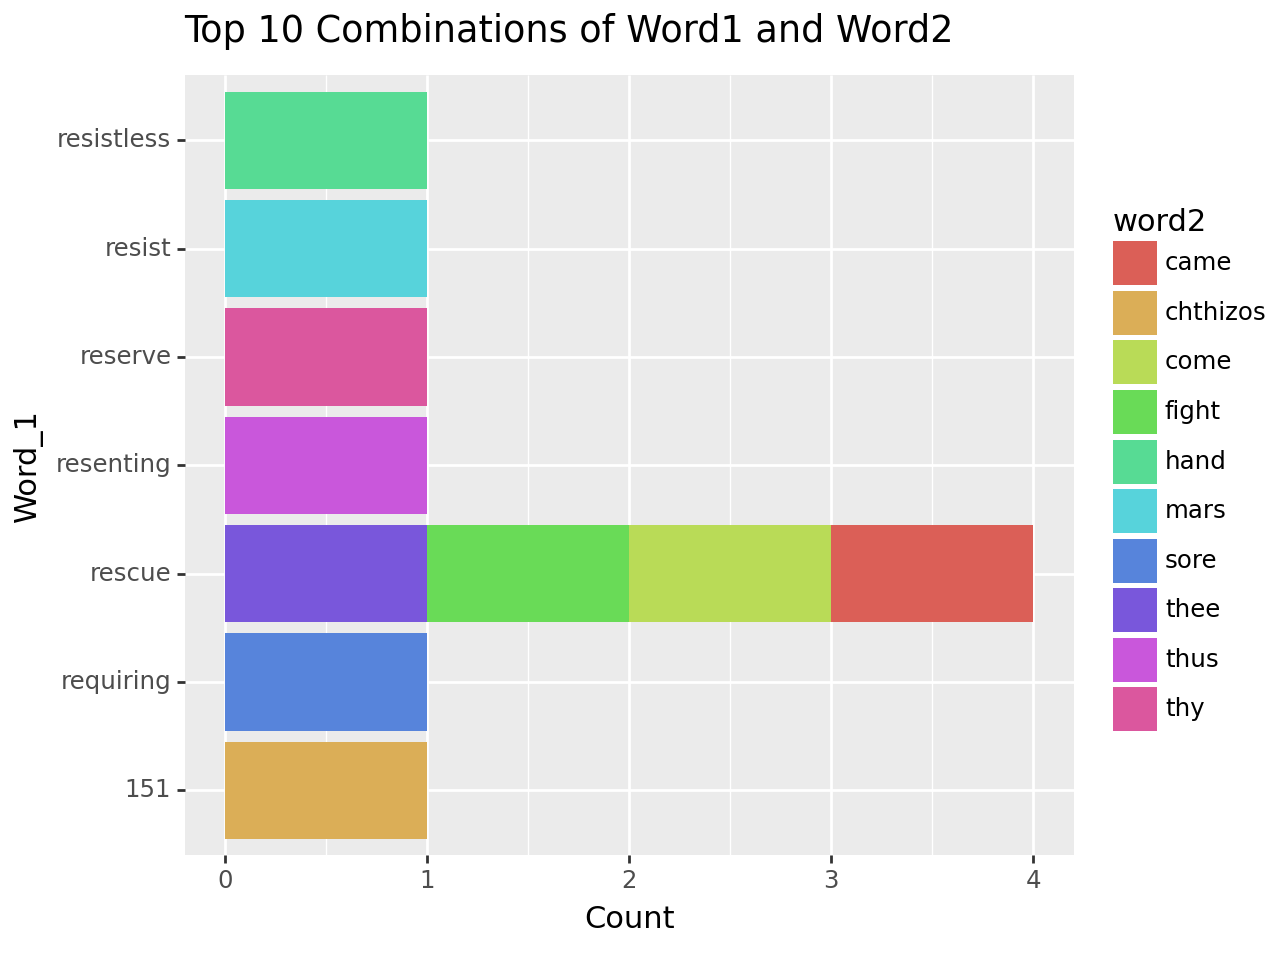

In [54]:
## Visualize Network Graph

from plotnine import ggplot, aes, geom_bar, coord_flip, labs

df['word1'] = df['word1'].astype(str)     # Convert 'word1' to string for categorical representation
plot = (ggplot(df.head(10), aes(x='word1', y='n', fill='word2')) +
        geom_bar(stat='identity') +
        coord_flip() +
        labs(x='Word_1', y='Count', title='Top 10 Combinations of Word1 and Word2'))

print(plot)